# Merev differenciálegyenletek


A közönséges differenciálegyenletekre felírt kezdeti érték problémák numerikus megoldása során egyes egyenletek esetén azt tapasztalhatjuk, hogy az explicit numerikus sémák nem működnek, vagy nagyon nem hatékonyak, mert a kívánt pontosság elérése érdekében nagy mértékben le kell, hogy csökkentsék a lépésközt. Az ilyen esetekben mondják, hogy a differenciálegyenlet *merev*. 

**Definíció helyett:** A merev differenciálegyenletek fenti meghatározása elnagyoltnak és pontatlannak tűnik, de az a helyzet, hogy ennek a fogalomnak általánosan elfogadott egzakt definíciója ezidáig nincs. Az irodalomban különböző megközelítések mentén haladva szokták körülírni a merev egyenleteket:

1. olyan egyenletek, amelyekre az explicit sémák nem (elég hatékonyan) működnek;

2. a lépésköz nagyságát nem az elérni kívánt pontosság, hanem stabilitási kritériumok szabják meg;

3. ugyanez szemléleteseben: adott pontosság eléréséhez nemcsak ott kell kicsire választani a lépésközt, ahol a megoldás nagyon oszcillál, hanem ott is, ahol a megoldás egyébként sima; 

4. ennek talán az okára világít rá: a megoldások lassan változnak, de a közeli integrálgörbék, gyorsan távolodnak egymástól, ezért fontos a kis lépésköz választás;

5. leginkább matematikai definíció, mely még mindig nem elég precíz és messze nem minden esetben alkalmazható: egy $\dot{x}=f(x)$ autonóm rendszer merev, ha a $\partial_x f$ Jacobi mátrix $\lambda_i$ sajátértékeire minden pontban igaz, hogy $Re (\lambda_i)\le 0$ és a $S=\frac{\max_i |\lambda_i|}{\min_i |\lambda_i|}$ ún. *merevségi hányadosra* $S\gg 1$ teljesül.
 
**Megjegyzés:** Létezik olyan példa, hogy két különböző differenciálegyenlet rendszernek ugyanaz az analitikus megoldása, de míg az egyik egyenlet merev, a másik nem az. Ezért fontos azt kihangsúlyozni, hogy a merevség nem a megoldásnak, hanem magának a differenciálegyenletnek a tulajdonsága, az egyenlet numerikus megoldás során mutatott viselkedését jellemzi.

Merev egyenletek megoldására általában jól használhatók az implicit sémák. A Scipy három implicit megoldót ajánl merev egyenletekhez, ezek a 'Radau', 'BDF' és az 'LSODA', melyek közül az utóbbi érdekessége, hogy automatikusan váltogat egy explicit és egy implicit séma között (stiffness detection).

A következő példában egy merev differenciálegyenletet fogunk megoldani két különböző (explicit és implicit) numerikus sémával, és összevetjük a kapott eredményeket.


## Példa: a Robertson-féle autokatalitikus kémiai reakció

A merev differenciálegyenletek egyik klasszikus példája a Robertson-féle autokatalitikus folyamat, mely három anyag $X$, $Y$ és $Z$ egymásba alakulását írja le az alábbi egyenletek szerint:

\begin{align}
X &\stackrel{k_1}{\longrightarrow} Y \\
Y + Y &\stackrel{k_2}{\longrightarrow} Z + Y\\
Y + Z &\stackrel{k_3}{\longrightarrow} X + Z,
\end{align}

ahol a nyilak felett a megfelelő reakciósebességi állandókat tüntettük fel, melyek értéke Robertson példájában $k_1=0.04$, $k_2=3.0\times 10^7$ és $k_3=1.0\times 10^4$. A fenti egyenletrendszer értelmezése:

* Az $X$ anyag önmagában képes átalakulni $Y$ anyaggá (1), de ez a reakció megfordítható $Z$ anyag jelenlétében, ahol a fordított irányú folyamatnál $Z$ mint katalizátor van jelen (3). /Ilyen a valóságban nincs -- a szerk./

* Az $Y$ anyag katalizálja önmaga átalakulását $Z$ anyaggá.

A Robertson-modell differenciálegyenlet rendszere:
\begin{align}
\dot{x} &= -0.04x+10^4 yz\\
\dot{y} &= 0.04x -10^4 yz -3\times 10^7 y^2 \\
\dot{z} &= 3\times 10^7 y^2
\end{align}

A követkető program a SciPy két különböző ODE integrátor függvényét hasonlítja össze: 

* Az 'RK45' solver a MATLAB ode45 megoldójának felel meg, egy explicit negyed-ötödrendű Runge-Kutta eljárás adaptív lépésköz választással, mely nem alkalmas merev differenciálegyenletek megoldására.

* A 'Radau' pedig egy ötödrendű implicit Runge-Kutta módszer, ami jól kezeli a merev egyenleteket.

A simulation report-okból látható, hogy az 'RK45' explicit solver nagyságrendekkel több pontban számolja ki az egyenlet jobb oldalát, mint az implicit megoldó, az adaptív lépésköz választás miatt pedig hibát generál, mivel a lépésköz nagysága a gépi pontosság alá csökken.


4-5-öd rendű Runge-Kutta módszer adaptív lépésköz válaztással:
Függvénykiértékelések száma: 11168
A differenciálegyenlet numerikus integrálása problémába ütközött.
Required step size is less than spacing between numbers.

5-öd rendű implicit Runge-Kutta módszer:
Függvénykiértékelések száma: 248
A differenciálegyenlet numerikus integrálása sikeresen lefutott.
The solver successfully reached the end of the integration interval.


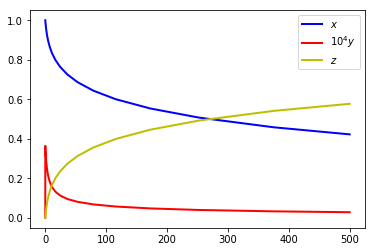

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def report(s):
    """
    Diffegyenlet solver reportáló függvény
    """
    
    print("Függvénykiértékelések száma: " + str(s.nfev))
    
    if s.success:
        print("A differenciálegyenlet numerikus integrálása sikeresen lefutott.")
    else:
        print("A differenciálegyenlet numerikus integrálása problémába ütközött.")
        
    print(s.message)
    
k1 = 0.04
k2 = 3.e7
k3 = 1.e4

robertson = lambda t, r: np.array([-k1*r[0] + k3*r[1]*r[2], 
                                    k1*r[0] - k3*r[1]*r[2] - k2*r[1]**2.0,
                                    k2*r[1]**2.0])

r0 = np.array([1.0, 0.0, 0.0])

print("\n4-5-öd rendű Runge-Kutta módszer adaptív lépésköz válaztással:")
sol = solve_ivp(robertson, (0, 500), r0, method='RK45')
report(sol)

print("\n5-öd rendű implicit Runge-Kutta módszer:")
sol = solve_ivp(robertson, (0, 500), r0, method='Radau')
report(sol)

# Megoldás kirajzoltatása
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sol.t, sol.y[0],'b-',lw=2,label='$x$')
ax.plot(sol.t, 1e4*sol.y[1],'r-',lw=2,label='$10^4 y$')
ax.plot(sol.t, sol.y[2],'y-',lw=2,label='$z$')

ax.legend();

## Feladat

Keressünk érdeked mérnöki vagy fizikai alkalmazásban előforduló merev differenciálegyenletet és próbáljuk integrálni explicit és implicit sémák segítségével.

# Hibrid dinamikai rendszerek


Hibrid dinamikai rendszer alatt olyan dinamikai rendszereket értünk, mely az időfejlődés során a folytonos és diszkrét dinamikai rendszerek sajátosságait egyaránt mutatja. Tehát a rendszert leíró állapotvektor időfejlődését egy adott pontig valamilyen differenciálegyenlet írja le, majd a rendszer egy előre definiált diszkrét dinamikát követve egy új állapotba ugrik, ahonnan kezdve az időfejlődés ismét folytonos lesz, de lehetséges éppen, hogy innentől fogva az időfejlődést valamilyen más differenciálegyenlet írja le. A pontos definíció a [8] jegyzetben található meg.

A mindennapi életben gyakran találkozunk hibrid dinamikai rendszerekkel. Ilyenek az ütközések, a pattogó labda (lásd alább) és az olyan folyamatirányítási megoldások mint például a vasaló fűtése. A vasaló esetén a felső kritikus hőmérséklet eléréséig a fűtőszál be van kapcsolva, utána pedig kikapcsol és addig marad kikapcsolt állapotban, míg a vasaló az alsó kritikus hőmérséklet alá nem hűl.

A hibrid dinamikai rendszerek szimulációjának alapfeltétele, hogy a rendszer jóldefiniált legyen, azaz tetszőleges szóbajövő kezdeti feltétel mellett a megoldás egyértelmű legyen. A numerikus szimulációra az alábbi megközelítések terjedtek el:

1. Közelítés sima dinamikai rendszerrel. Ütközések modellezhetők úgy például, hogy a testeket kis távolságon működő taszító potenciál veszi körül és a rendszert mind autonóm KDE-el leírt rendszert szimuláljuk. Nem világos, hogy az így kapott megoldás hogy viszonyul az eredeti hibrid rendszer megoldásához. További hátrány, hogy ez a megközelítés nem alkalmazható, ha maguk az ütközések érdekelnek bennünket.

2. Közelítés diszkrét idejű dinamikai rendszerrel (timestepping method): nem cél a pontos eseménydetektálás. Az időtartományt $\Delta t>0$ nagyságú szakaszokra osztjuk és minden egyes lépés végén megvizsgáljuk, hogy történt-e diszkrét ugrás, és ha igen, akkor ennek megfelelően léptetjük a dinamikát (pl: földet ért-e a pattogó labda, ha igen, akkor a sebessége ellentétes előjelűre vált).

3. Esemény detektálás: az autonóm KDE-et addig integráljuk, míg a rendszer olyan állapotba nem ér, ahonnan aztán diszkrét dinamikával ugrik tovább (pl: pattanó labda), majd innentől kezdve a módosított jobboldalú egyenletet ingeráljuk.

4. Differenciál-algebrai egyenletek (DAE): implicit módszer, ahol az, hogy melyik egyenlet aktív a dinamika "diszkrét része" által van vezérelve.


## Példa: A pattogó labda

Tekintsük egy $h>0$ magasságból, homogén gravitációs térben elejtett labdát, mely valahányszor a padlónak ütközik, mozgási energiájának $1-\gamma^2$-szeresét veszti el, ahol $\gamma\in (0,1)$. A labda mozgását a levegőben az
\begin{align}
\dot{y} &= v \\
\dot{v} &= -g
\end{align}
differenciálegyenlet rendszer írja le, ahol $g>0$ a gravitációs gyorsulás. A földet érés pillanatában a labda sebessége (idealizált esetben) nulla idő alatt $-\gamma$ szorosára változik: $v\mapsto -\gamma v$. Világos, hogy a pattogó labda mozgását hibrid dinamikai rendszer írja le.

Ezen rendszer érdekessége, hogy ahogyan a visszapattanó labda egyre kisebb és kisebb maximális magasságot ér el, a két visszapattanás között eltelt idő is egyre rövidebb lesz, melynek következtében a labda véges sok idő alatt végtelen sokat pattan. A hibrid dinamikai rendszerek elméletében ezt hívják Zénón-jelenségnek (Szintén van precíz, formális definíciója, de ez bennünket itt most nem érdekel.). A Zénón-jelenség sok fontos mérnöki alkalmazásban előfordul (pl. robot dinamika) és egyáltalán nem könnyű megfelelő minőségű számítógépes szimulációt készíteni.

A pattogó labda szimulációját esemény detektáláson alapuló módszerrel valósítjuk meg. Sajnos a Scipy csomagban rendelkezésre álló ODE solverek (pl.: a MATLAB és Julia solvereivel ellentétben) nem támogatják az esemény detektálást, ezért a szimulációs feladatot a DifferetialEquations.jl csomagban elérhető solverek segítségével oldjuk meg.

In [1]:
# Ez a feladat megoldható "csak Julia"-ból, ezért egyszerűen csak állítsuk át a kernelt.
# A példa kódot innen vettem: https://diffeqflux.sciml.ai/stable/examples/bouncing_ball/

using DifferentialEquations

function f(du,u,p,t)
  du[1] = u[2]
  du[2] = -p[1]
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
    # Ha ez a feltétel teljesül, akkor esemény "triggerelődik".
    u[1]
end  

function affect!(integrator)
  integrator.u[2] = -integrator.p[2]*integrator.u[2]
end

cb = ContinuousCallback(condition,affect!) # argumentumokban az esemény és a reakció függvények vannak
u0 = [50.0,0.0]
tspan = (0.0,31.0)
p = [9.8, 0.8]
prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob,Tsit5(),callback=cb);

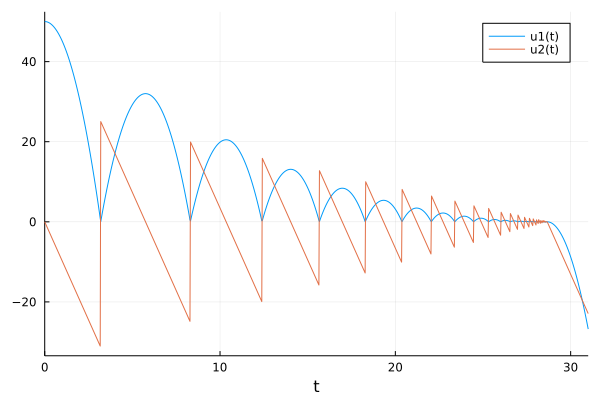

In [3]:
using Plots

plot(sol)

Látható, hogy kb. fél perc után, amikro a Zénón-jelenség kezdődik, a numerikus megoldás elveszi fizikai realitását és az ábra azt mutatja, hogy a pattogó labda a padlót áttörve elindult a Föld középpontja felé, ami a valóságban nyilván nem történik meg. **Próbáljuk meg valahogy kiküszöbölni ezt a problémát!**

## Feladat

A https://www.ecse.rpi.edu/~agung/course/vanderschaft.pdf jegyzet 54. oldalán ismerteti a szerző a szögnek ütköző inga problémáját. Készítsük el az ütköző inga animált szimulációját. Ehhez kiindulási alapnak vehetjük a 3. gyakorlaton bemutatott inga szimulációt. Gondolkodjunk el azon (hatalmas plusz pont, aki le is programozza), hogy egy pozitív vastagságú, kör keresztmetszetű szög esetén hogyan lehetne szimulálni azt a jelenséget, amikor az inga fonala elég nagy sebességgel ütközik a szögnek, és az inga feltekeredik.

**Szorgalmi feladat: a fenti jegyzet 2.2 fejezetében leírt bármely, itt nem tárgyalt hibrid dinamikai rendszer szimulációjának az elkészítése (pl.: a vasaló fűtése egyszerűen modellezhető).**

# További olvasnivalók

1. https://en.wikipedia.org/wiki/Stiff_equation

2. https://www.mathworks.com/company/newsletters/articles/stiff-differential-equations.html

3. https://www.mathworks.com/help/matlab/math/solve-stiff-odes.html (Van der Pol oszcillátor, a merev diffegyenletek egyik állatorvosi lova)

4. https://en.wikipedia.org/wiki/Van_der_Pol_oscillator (akit esetleg érdekel, hogy mi az a Van der Pol oszcillátor)

5. https://scipython.com/book2/chapter-8-scipy/examples/solving-a-system-of-stiff-odes/ (a merev egyenletes példát innen vettem)

6. https://en.wikipedia.org/wiki/Hybrid_system

7. https://en.wikipedia.org/wiki/Bouncing_ball

8. https://www.ecse.rpi.edu/~agung/course/vanderschaft.pdf (hibrid dinamikai rendszer egyetemi jegyzet)